In [15]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Function to scale an input image by a given percent. For example, 100% will maintain the same size of image, 200% will double.
def scale_image(input_image, scale):

    height = input_image.shape[0] * scale // 100
    width = input_image.shape[1] * scale // 100

    return cv2.resize(input_image, (width, height), interpolation = cv2.INTER_AREA)

In [17]:
# Function to determine the scale of the image, given an input image that contains a white scalebar, and the length of that bar in microns. Returns 0 if scale cannot be determined.
def find_microns_per_pixel(input_image,scalebar_length_in_um, debug_flag = False):

  # Filter for white
  lower_white = np.array([200, 200, 200])
  upper_white = np.array([255, 255, 255])
  white_mask = cv2.inRange(input_image, lower_white, upper_white)

  # Count lines of white pixels, tracking the length of the longest continuous line
  longest_length = 0
  x1 = 0
  x2 = 0
  y = 0

  for i in range(white_mask.shape[0]):

    # Reset all variables used to track status each time we go through a row
    first_col_detected_white_num = 0
    last_col_detected_white_num = 0
    white_col_detected = False
    temp_length = 0

    for j in range(white_mask.shape[1]):

      if white_mask[i][j] == 255 and not white_col_detected:
        # Remember the column of the first white pixel detected.
        first_col_detected_white_num = j
        white_col_detected = True

      elif white_col_detected and white_mask[i][j] == 0:
        # After the end of a continous line of white, remember the length of that line, and its endpoint.
        last_col_detected_white_num = j - 1
        temp_length = last_col_detected_white_num - first_col_detected_white_num
        break

    # If the line we just found is the largest, remember its length, start, and end points.
    if temp_length > longest_length:
      longest_length = temp_length
      x1 = first_col_detected_white_num
      x2 = last_col_detected_white_num
      y = i

  if True == debug_flag:
    # Mark the end of the longest line with a red dot so we can confirm visually
    copy = input_image.copy()
    copy[y:y+20,x1-1:x1] = (255,70,100)
    copy[y:y+20,x2:x2+1] = (255,70,100)

    print(x1, x2, y)
    print(copy.shape)

    cv2_imshow(white_mask)
    cv2_imshow(copy)

  if (longest_length == 0):
    print("Error decoding scale bar")
    return 0

  um_per_pixel = scalebar_length_in_um / longest_length

  return um_per_pixel

In [18]:
# Function: take a binary cell image, and fill in gaps on the edges,
# so that dark sections on the edge of the image are not interpreted as edges of the colony
# in subsequent analysis

# Returns: an image of the same size as input that shows which pixels were filled in to complete this bridging process
# Modifies: the input image.
# Parameter: max_range_to_fill determines the maximum radius of gaps that will be bridged.
# A dark pixel must be within this distance of a light pixel on EACH side to be filled in, or a single side and above.
def bridge_gaps_on_edges(input_image, max_range_to_fill, top_row=1, bottom_row=1, left_side=1, right_side=1):

  blank = np.zeros_like(input_image, dtype=(int,3))

  if (top_row):
    # corner cases: for each corner, only bridge if there are light
    # pixels both above and to the side of the dark pixel under consideration.
    # always accomplished by looking from the corner towards the center of the image

    # top row left case, look right and down
    for i in range(0,max_range_to_fill):
      if input_image[0,i] == 0 and 255 in input_image[0,i:i+max_range_to_fill] and 255 in input_image[0:max_range_to_fill, i]:
        input_image[0,i] = 255
        blank[0,i] = (255,0,255)

    #top row right case, look left and down
    for i in range(input_image.shape[1]-max_range_to_fill,input_image.shape[1]):
      if input_image[0,i] == 0 and 255 in input_image[0,i-max_range_to_fill:i] and 255 in input_image[0:max_range_to_fill, i]:
        input_image[0,i] = 255
        blank[0,i] = (255,0,255)

    for i in range(max_range_to_fill,input_image.shape[1]-max_range_to_fill):
      if input_image[0,i] == 0 and 255 in input_image[0,i-max_range_to_fill:i] and 255 in input_image[0,i:i+max_range_to_fill]:
        input_image[0,i] = 255
        blank[0,i] = (255,0,255)

  if(bottom_row):
    #bottom side left case, look right and up
    for i in range(0,max_range_to_fill):
      if input_image[-1,i] == 0 and 255 in input_image[-1,i:i+max_range_to_fill] and 255 in input_image[-(max_range_to_fill+1):-1,i]:
        input_image[-1,i] = 255
        blank[-1,i] = (255,0,255)

    #bottom side right case, look left and up
    for i in range(input_image.shape[1]-max_range_to_fill,input_image.shape[1]):
      if input_image[-1,i] == 0 and 255 in input_image[-1,i-max_range_to_fill:i] and 255 in input_image[-(max_range_to_fill+1):-1,i]:
        input_image[-1,i] = 255
        blank[-1,i] = (255,0,255)

    for i in range(max_range_to_fill,input_image.shape[1]-max_range_to_fill):
      if input_image[-1,i] == 0 and 255 in input_image[-1,i-max_range_to_fill:i] and 255 in input_image[-1,i:i+max_range_to_fill]:
        input_image[-1,i] = 255
        blank[-1,i] = (255,0,255)

  if (left_side):
    #left side top case, look down and right
    for i in range(0,max_range_to_fill):
      if input_image[i,0] == 0 and 255 in input_image[i:i+max_range_to_fill,0] and 255 in input_image[i,0:max_range_to_fill]:
        input_image[i,0] = 255
        blank[i,0] = (255,0,255)

    #left side bottom case, look up and right
    for i in range(input_image.shape[0]-max_range_to_fill,input_image.shape[0]):
      if input_image[i,0] == 0 and 255 in input_image[i-max_range_to_fill:i,0] and 255 in input_image[i,0:max_range_to_fill]:
        input_image[i,0] = 255
        blank[i,0] = (255,0,255)

    for i in range(max_range_to_fill,input_image.shape[0]-max_range_to_fill):
      if input_image[i,0] == 0 and 255 in input_image[i-max_range_to_fill:i,0] and 255 in input_image[i:i+max_range_to_fill,0]:
        input_image[i,0] = 255
        blank[i,0] = (255,0,255)

  if (right_side):
    #right side top case, look down and left
    for i in range(0,max_range_to_fill):
      if input_image[i,-1] == 0 and 255 in input_image[i:i+max_range_to_fill,-1] and 255 in input_image[i,-(max_range_to_fill+1):-1]:
        input_image[i,-1] = 255
        blank[i,-1] = (255,0,255)

    #right side bottom case, look up and left
    for i in range(input_image.shape[0]-max_range_to_fill,input_image.shape[0]):
      if input_image[i,-1] == 0 and 255 in input_image[i-max_range_to_fill:i,-1] and 255 in input_image[i,-(max_range_to_fill+1):-1]:
        input_image[i,-1] = 255
        blank[i,-1] = (255,0,255)

    for i in range(max_range_to_fill,input_image.shape[0]-max_range_to_fill):
      if input_image[i,-1] == 0 and 255 in input_image[i-max_range_to_fill:i,-1] and 255 in input_image[i:i+max_range_to_fill,-1]:
        input_image[i,-1] = 255
        blank[i,-1] = (255,0,255)

  # Draw lines to show the limits of the corner cases
  blank[0:5,max_range_to_fill] = (0,0,255)
  blank[0:5,-max_range_to_fill] = (0,0,255)
  blank[-6:-1,max_range_to_fill] = (0,0,255)
  blank[-6:-1,-max_range_to_fill] = (0,0,255)

  blank[max_range_to_fill,0:5] = (0,0,255)
  blank[-max_range_to_fill,0:5] = (0,0,255)
  blank[max_range_to_fill,-6:-1] = (0,0,255)
  blank[-max_range_to_fill,-6:-1] = (0,0,255)

  return blank

In [19]:
# Function: Set each edge of the input image to (0,0,0) or 0. Modifies the input image.
def trim_edges_to_black(input_image, grayscale=False):
  copyimg = input_image.copy()
  if grayscale == True:
    copyimg[:,0] = 0
    copyimg[:,-1] = 0
    copyimg[0,:] = 0
    copyimg[-1,:] = 0
  else:
    copyimg[:,0] = (0,0,0)
    copyimg[:,-1] = (0,0,0)
    copyimg[0,:] = (0,0,0)
    copyimg[-1,:] = (0,0,0)
  return copyimg

In [20]:
SCALE_FACTOR = 100
MAX_BRIDGE_RADIUS = 95+50
RADIUS_FROM_EDGE = 20
BLUR_KERNEL = (1,1)
SCALE_BAR_LENGTH_UM = 50

NUM_COLONIES = 1

# Enter path to target image for analysis
path = 'path to image goes here'

Original Image


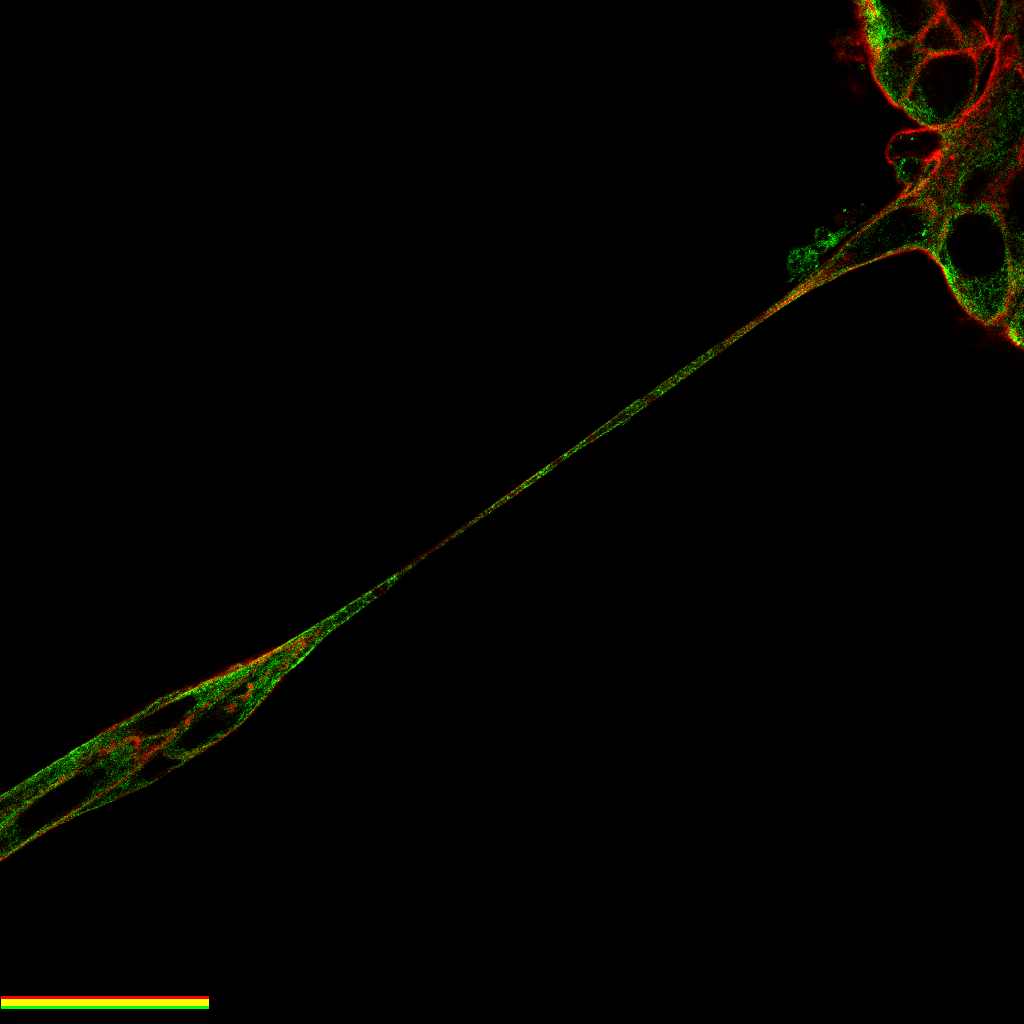

(1024, 1024, 3)


In [21]:
# Load the image for analysis
original_img = cv2.imread(path)

# original_img = original_img[0:-50,:]

print('Original Image')
cv2_imshow(original_img)

print(original_img.shape)

In [22]:
# Scale image for easier viewing if needed
img = scale_image(original_img,SCALE_FACTOR)

Colony mask


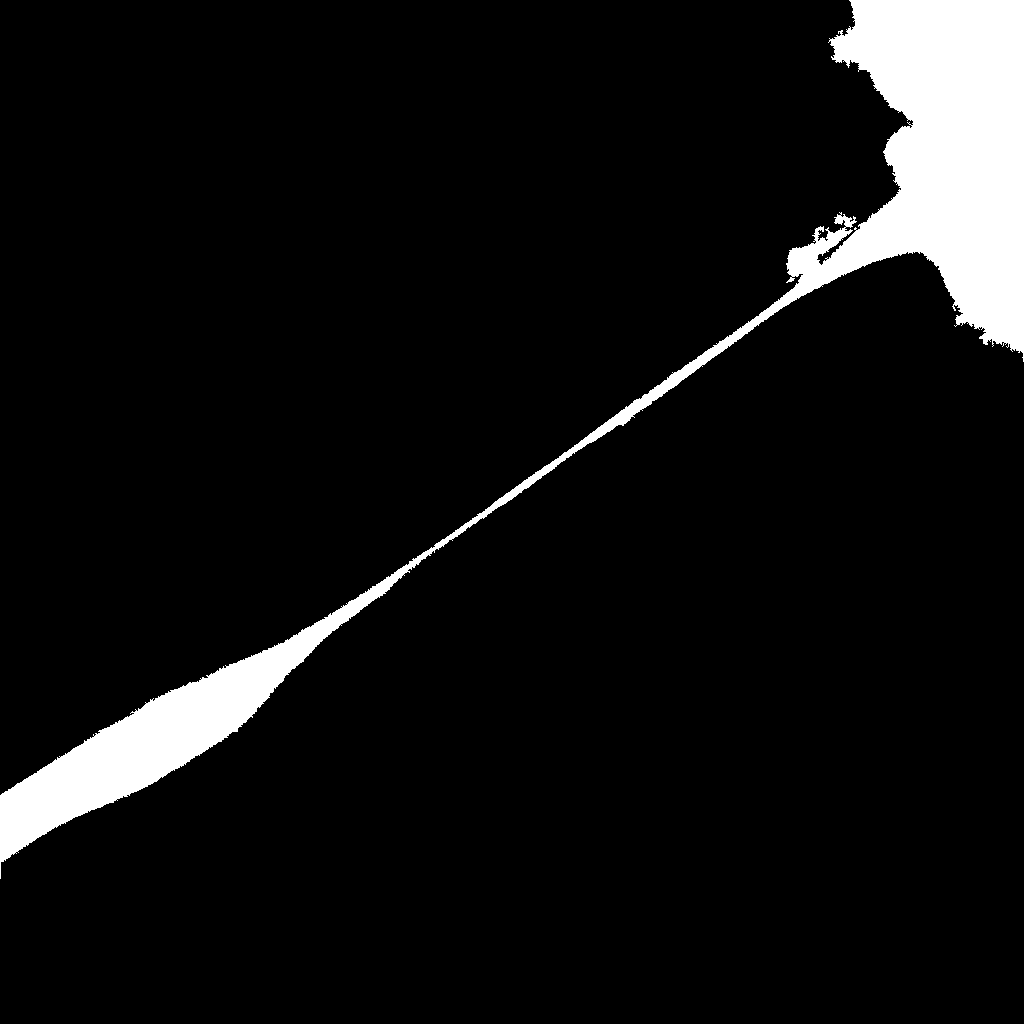

In [23]:
# Create a mask of all the colony excluding all negative space

# img = cv2.GaussianBlur(img, BLUR_KERNEL, 0)

# Filter to remove negative space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower_bound = np.array([0, 0, 15])
upper_bound = np.array([360, 255, 255])
mask = cv2.inRange(hsv, lower_bound, upper_bound)

bridge_gaps_on_edges(mask, MAX_BRIDGE_RADIUS)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours = sorted(contours, key=cv2.contourArea, reverse=True)

largest_contours = contours[0:NUM_COLONIES]

# Create a mask of the entire colony
filled_in = cv2.drawContours(np.zeros_like(mask), largest_contours, -1, 255, thickness=-1)
print("Colony mask")
cv2_imshow(filled_in)

Calculated outline


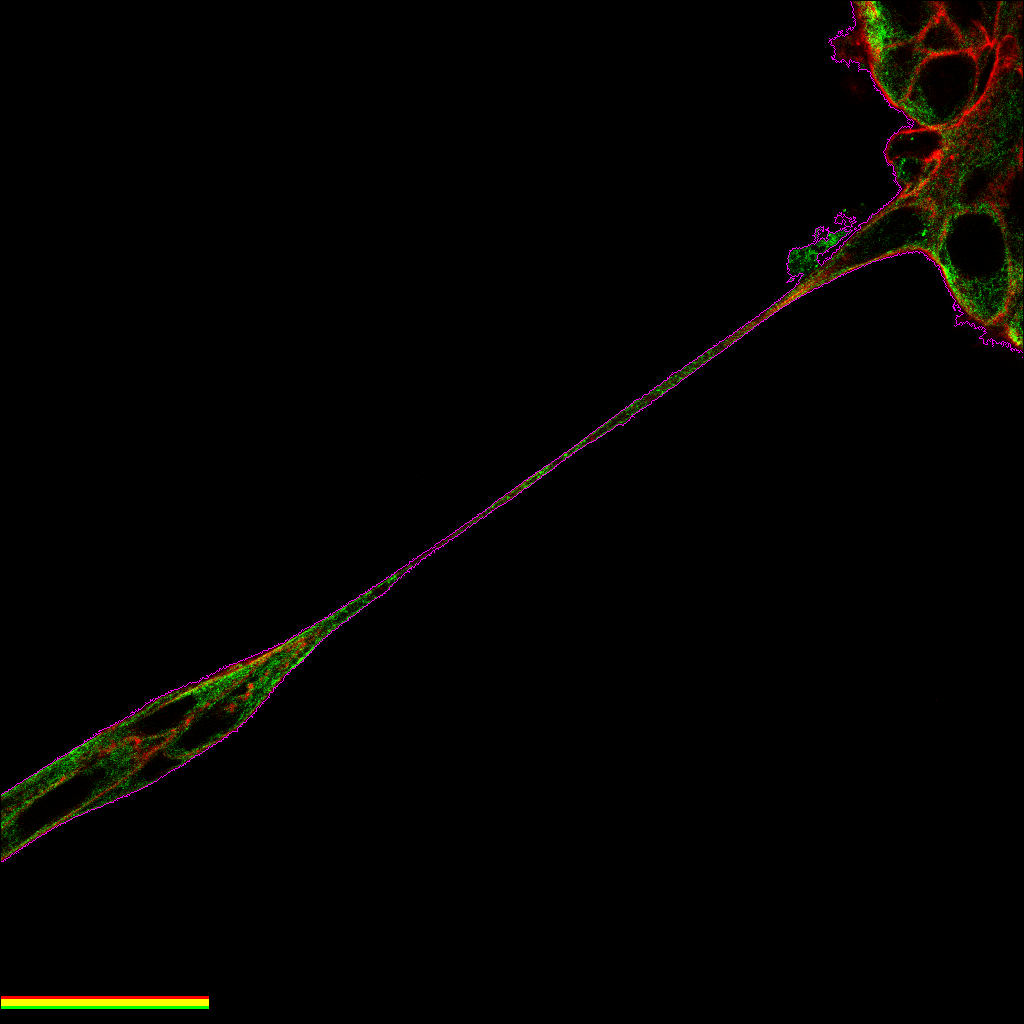

In [24]:
# Display the contour around the edge of the colony
grayscale_contour_image = cv2.drawContours(np.zeros_like(mask), largest_contours, -1, 255, thickness=1)
grayscale_contour_image = trim_edges_to_black(grayscale_contour_image, grayscale=True)

# Show an overlay of the calculated boundary of the colony with the image
print("Calculated outline")
cv2_imshow(trim_edges_to_black(cv2.drawContours(img.copy(), largest_contours, -1, (255, 0, 255), thickness=1)))

Edge of colony


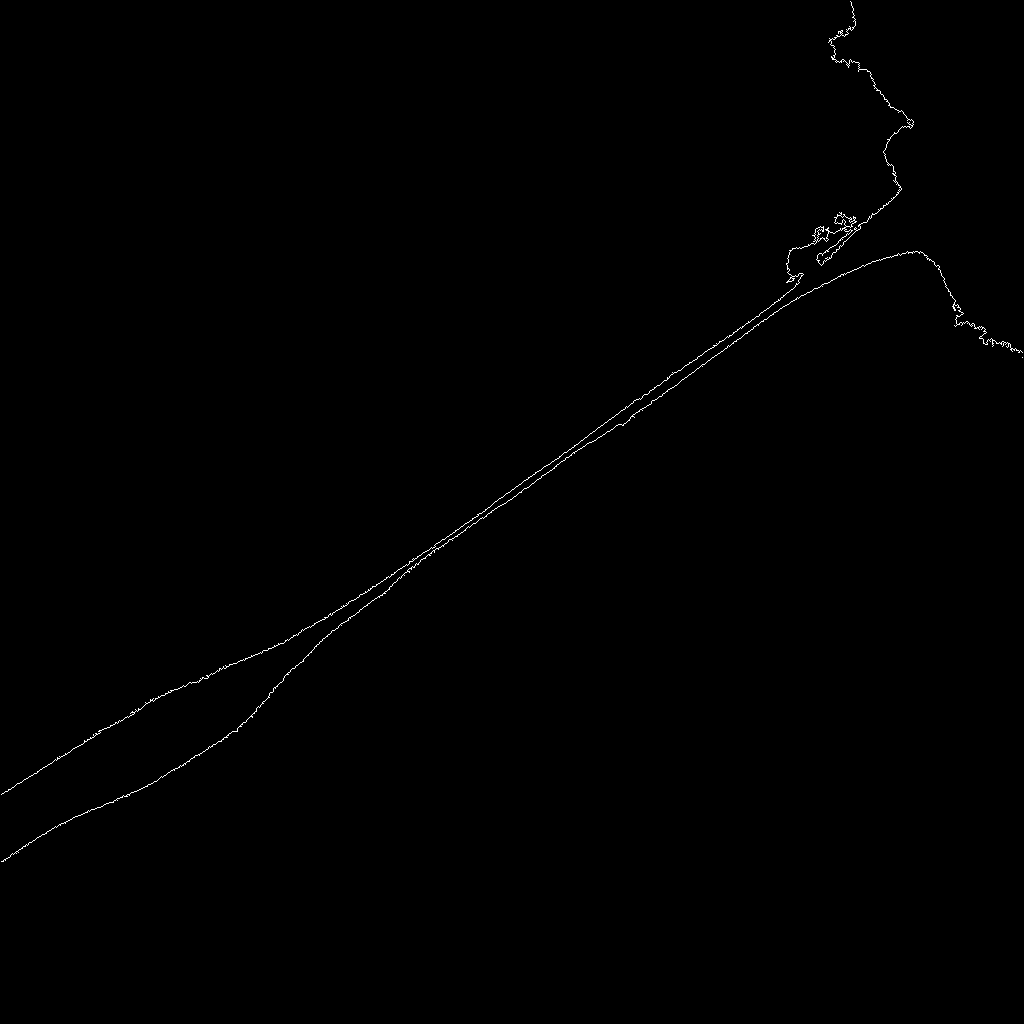

Edge region mask


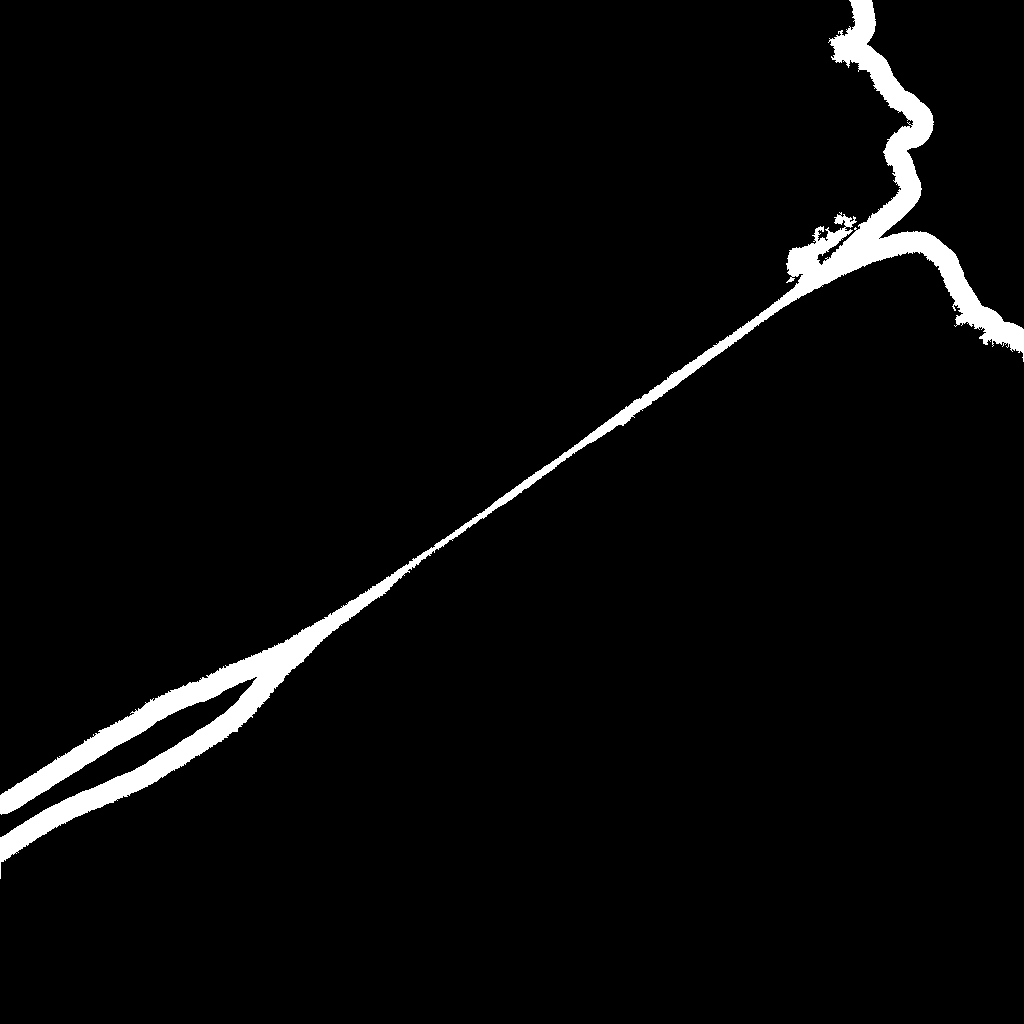

In [25]:
# Create a mask of the edges of the colony within a specified distance

print("Edge of colony")
cv2_imshow(grayscale_contour_image)

circle_mask = grayscale_contour_image.copy()

for i in range(grayscale_contour_image.shape[0]):
  for j in range(grayscale_contour_image.shape[1]):

    if grayscale_contour_image[i][j] > 0:
      cv2.circle(circle_mask, (j,i), RADIUS_FROM_EDGE, 255, thickness=-1)

edge_mask = cv2.bitwise_and(circle_mask, filled_in)

print("Edge region mask")
cv2_imshow(edge_mask)

In [26]:
img_nonblur = scale_image(original_img,SCALE_FACTOR)
ums_per_pixel = find_microns_per_pixel(img_nonblur,SCALE_BAR_LENGTH_UM)

print(ums_per_pixel)

Error decoding scale bar
0


Edge region


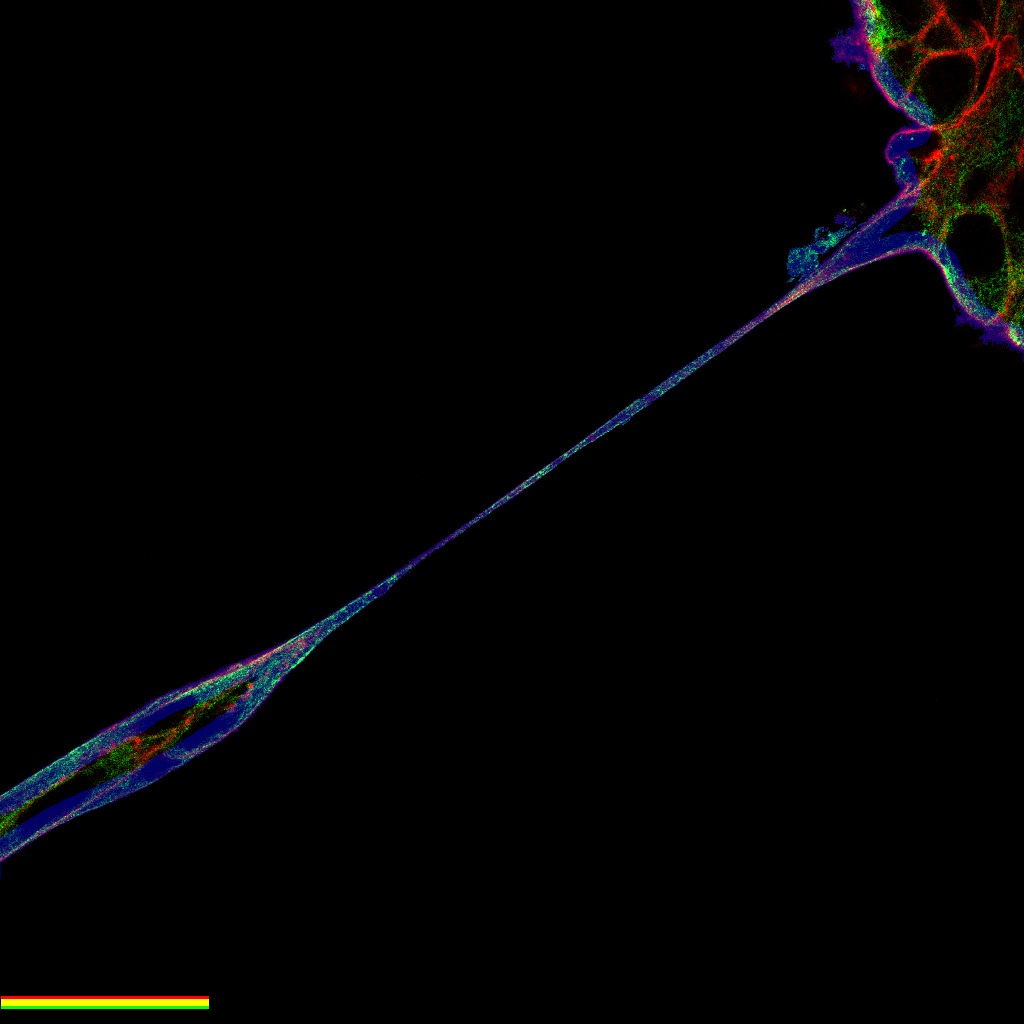

Interior region


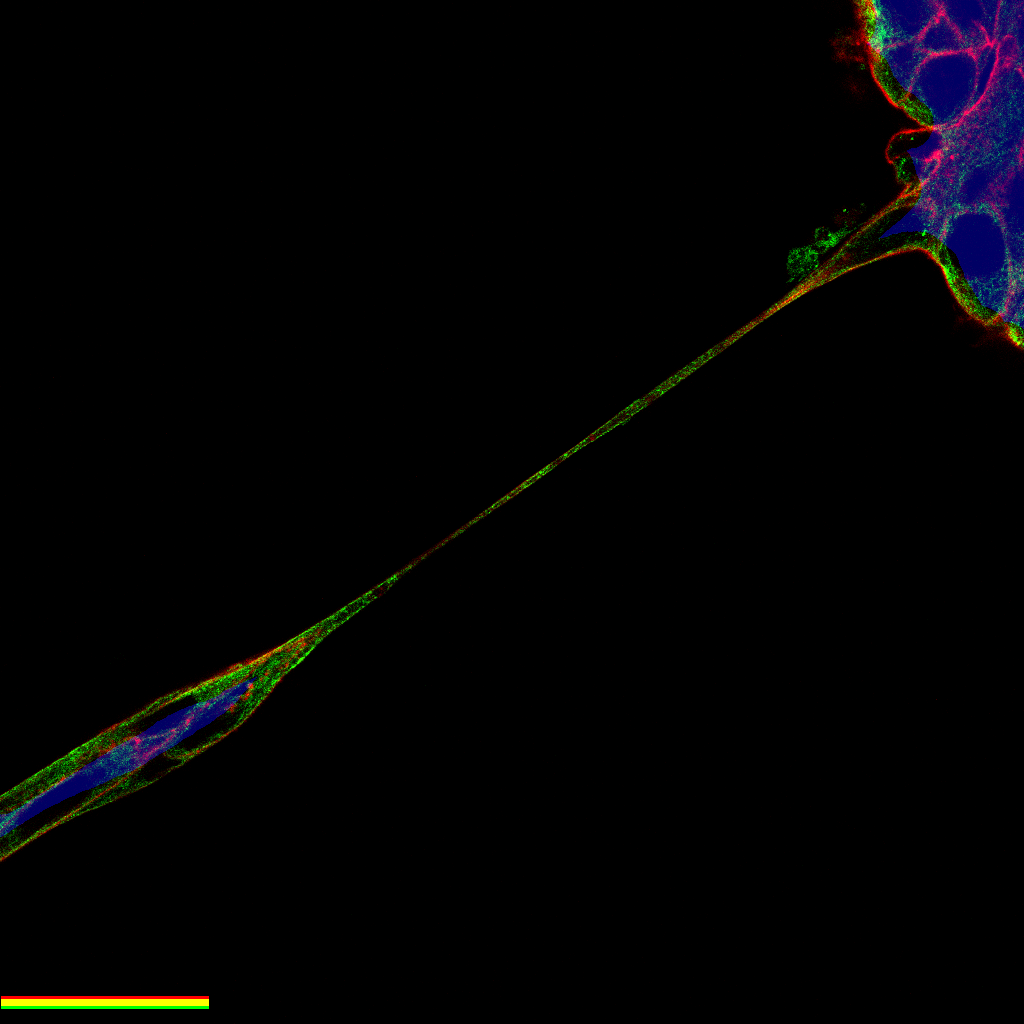

In [13]:
# Calculate the relative concentration of stained protein in each region

interior_copy = img_nonblur.copy()
edge_copy = img_nonblur.copy()

total_green_sum = 0
total_num_samples = 0
for i in range(img_nonblur.shape[0]):
  for j in range(img_nonblur.shape[1]):

    if filled_in[i][j] > 0:
      total_green_sum += img_nonblur[i][j][1]
      total_num_samples += 1

      # Show the interior region in blue
      if edge_mask[i][j] == 0:
        interior_copy[i][j][0]+= 100

edge_green_sum = 0
edge_num_samples = 0
for i in range(img_nonblur.shape[0]):
  for j in range(img_nonblur.shape[1]):

    if edge_mask[i][j] > 0:
      edge_green_sum += img_nonblur[i][j][1]
      edge_num_samples += 1

      # Show the edge region in blue
      edge_copy[i][j][0]+= 100

interior_green_sum = total_green_sum - edge_green_sum
interior_num_samples = total_num_samples - edge_num_samples

total_average_intensity = total_green_sum / total_num_samples
edge_average_intensity = edge_green_sum / edge_num_samples
interior_average_intentsity = interior_green_sum / interior_num_samples

print("Edge region")
cv2_imshow(edge_copy)

print("Interior region")
cv2_imshow(interior_copy)

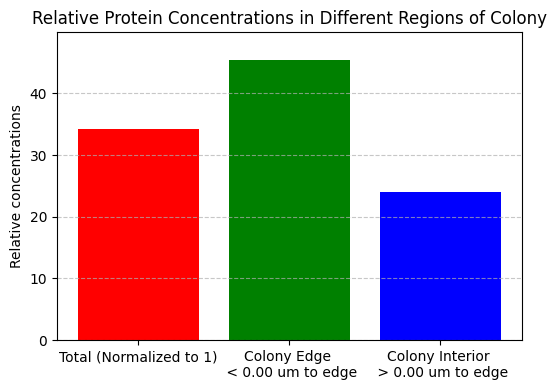

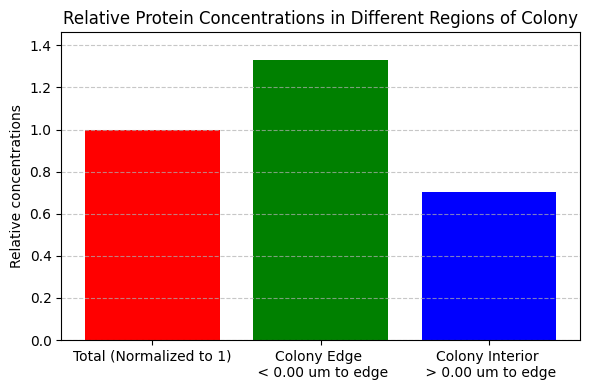

In [14]:
# Plot the resulting data in a bar graph for analysis
import matplotlib.pyplot as plt

# Create labels for the regions (optional)
region_labels = ['Total (Normalized to 1)', f'Colony Edge \n < {ums_per_pixel*RADIUS_FROM_EDGE:.2f} um to edge', f'Colony Interior \n > {ums_per_pixel*RADIUS_FROM_EDGE:.2f} um to edge']


intensity_list = [total_average_intensity, edge_average_intensity, interior_average_intentsity]
figsize = (6, 4)
# Create a bar graph
plt.figure(figsize=figsize)
plt.bar(np.arange(len(intensity_list)), intensity_list, tick_label=region_labels, color=['red', 'green', 'blue'])
# plt.xlabel('Regions')
plt.ylabel('Relative concentrations')
plt.title('Relative Protein Concentrations in Different Regions of Colony')
plt.ylim(0, 1.1*max(intensity_list))  # Set the y-axis limit if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)

intensity_list = intensity_list / total_average_intensity

# Create a bar graph
plt.figure(figsize=figsize)
plt.bar(np.arange(len(intensity_list)), intensity_list, tick_label=region_labels, color=['red', 'green', 'blue'])
# plt.xlabel('Regions')
plt.ylabel('Relative concentrations')
plt.title('Relative Protein Concentrations in Different Regions of Colony')
plt.ylim(0, 1.1*max(intensity_list))  # Set the y-axis limit if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()